In [1]:
import numpy
import scipy

from metricdiversity.acquisitions.cas import ConstraintActiveSearchService
from metricdiversity.acquisitions.expected_metric_coverage import ExpectedMetricCoverageService
from metricdiversity.test_problems.problems import TwoHumps, EMI

from metricdiversity.utilities.sigopt_colors import *

import matplotlib.pyplot as plt
%matplotlib inline

## 2D test function

In [2]:
# For plotting satisfactory region
def f_1(x, scale_x=1):
  return numpy.exp(-0.5* ((x[0]-0.2)**2 + scale_x * (x[1]-0.5)**2))

def f_2(x, scale_y=1):
  return numpy.exp(-0.5* ((x[0]-0.8)**2 + scale_y *(x[1]-0.5)**2))

def ellipse_points(center, radius_x, radius_y, angle_rad=0):
  assert len(center) == 2
  num_points = 1000
  theta = numpy.linspace(0, 2 * numpy.pi, num_points)
  xs = radius_x * numpy.cos(theta) 
  ys = radius_y * numpy.sin(theta)
  if angle_rad != 0:
    rot_mat = numpy.array([
      [numpy.cos(angle_rad), -numpy.sin(angle_rad)],
      [numpy.sin(angle_rad), numpy.cos(angle_rad)],
    ])
    rotated = numpy.dot(rot_mat, numpy.array([xs, ys]))
    xs = rotated[0]
    ys = rotated[1]
    
  return xs + center[0], ys + center[1]

threshold = 0.85
radius = numpy.sqrt(-2 * numpy.log(threshold))
print(radius)
x_c1, y_c1 = ellipse_points([0.2, 0.5], radius, radius)
x_c2, y_c2 = ellipse_points([0.8, 0.5], radius, radius)
x_ell1, y_ell1 = ellipse_points([0.2, 0.5], radius, radius / 2)
x_ell2, y_ell2 = ellipse_points([0.8, 0.5], radius, radius / 2)


x_0 = numpy.linspace(0.2+radius, 0.8-radius, 100)
x_1 = numpy.ones(100) * 0.5
xxx = numpy.vstack((x_0, x_1)).T
y_0 = numpy.array([f_1(xx) for xx in xxx])
y_1 = numpy.array([f_2(xx) for xx in xxx])
yyy = numpy.vstack((y_0, y_1)).T

x_c1_p = x_c1[x_c1>=0.5]
y_c1_p = y_c1[x_c1>=0.5]
x_c2_p = x_c2[x_c2<=0.5]
y_c2_p = y_c2[x_c2<=0.5]
sorted_idx = numpy.argsort(y_c1_p)

0.5701209161182826


In [3]:
two_humps = TwoHumps()

In [4]:
cas = ConstraintActiveSearchService(
  parameters=two_humps.parameters,
  constraints=two_humps.constraints,
  punchout_radius=two_humps.punchout_radius_param,
  num_init_points=6,
)

In [5]:
for i in range(20):
  suggestion = cas.create_suggestion()
  values = two_humps.evaluate(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  cas.create_observation(observation)

 >>> x_next tensor([[0.4748, 0.5818]], dtype=torch.float64) eci tensor(0.9107, dtype=torch.float64)
 >>> x_next tensor([[0.5513, 0.3919]], dtype=torch.float64) eci tensor(0.9971, dtype=torch.float64)
 >>> x_next tensor([[0.5429, 0.7703]], dtype=torch.float64) eci tensor(0.9698, dtype=torch.float64)
 >>> x_next tensor([[0.5137, 0.1976]], dtype=torch.float64) eci tensor(0.9461, dtype=torch.float64)
 >>> x_next tensor([[0.3594, 0.4249]], dtype=torch.float64) eci tensor(0.9454, dtype=torch.float64)
 >>> x_next tensor([[0.6611, 0.5518]], dtype=torch.float64) eci tensor(0.9516, dtype=torch.float64)
 >>> x_next tensor([[0.3803, 0.2735]], dtype=torch.float64) eci tensor(0.6942, dtype=torch.float64)
 >>> x_next tensor([[0.4979, 0.9552]], dtype=torch.float64) eci tensor(0.6804, dtype=torch.float64)
 >>> x_next tensor([[0.2871, 0.5667]], dtype=torch.float64) eci tensor(0.6642, dtype=torch.float64)
 >>> x_next tensor([[0.6520, 0.6878]], dtype=torch.float64) eci tensor(0.5481, dtype=torch.float64)


In [6]:
cas_points = numpy.array(cas.get_points())
cas_values = numpy.array(cas.get_values())
cas_feasible_inds = numpy.array(cas.get_feasible_indices())

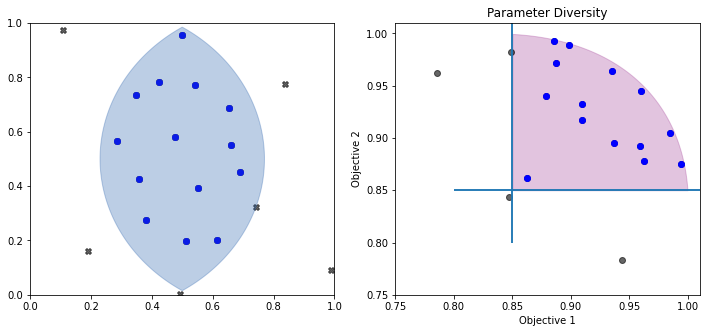

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(cas_points[:, 0], cas_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(cas_points[cas_feasible_inds, 0], cas_points[cas_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(cas_values[:, 0], cas_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(cas_values[cas_feasible_inds, 0], cas_values[cas_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Parameter Diversity")
plt.show()

In [8]:
emcs = ExpectedMetricCoverageService(
  parameters=two_humps.parameters,
  constraints=two_humps.constraints,
  punchout_radius=two_humps.punchout_radius_metric,
  num_init_points=6,
  hyperparameters=two_humps.fixed_lengthscales,
)

In [9]:
for i in range(20):
  suggestion = emcs.create_suggestion()
  values = two_humps.evaluate(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  emcs.create_observation(observation)

 >>> x_next [0.67958076 0.49680811] emc 1.0
 >>> x_next [0.55152027 0.36642515] emc 1.0
 >>> x_next [0.51075836 0.10324486] emc 1.0
 >>> x_next [0.35768074 0.31565468] emc 0.9609375
 >>> x_next [0.44194084 0.37287676] emc 0.994140625
 >>> x_next [0.62454249 0.19960163] emc 0.951171875
 >>> x_next [0.74691793 0.62124534] emc 0.998046875
 >>> x_next [0.40352126 0.13435702] emc 0.984375
 >>> x_next [0.31962712 0.22945082] emc 0.97265625
 >>> x_next [0.60994779 0.11648431] emc 0.8984375
 >>> x_next [0.2902266  0.43530387] emc 0.3671875
 >>> x_next [0.49752558 0.02887387] emc 0.96484375
 >>> x_next [0.5673487  0.24605876] emc 0.763671875
 >>> x_next [0.37803254 0.53220994] emc 0.04296875


In [10]:
emcs_points = numpy.array(emcs.get_points())
emcs_values = numpy.array(emcs.get_values())
emcs_feasible_inds = numpy.array(emcs.get_feasible_indices())

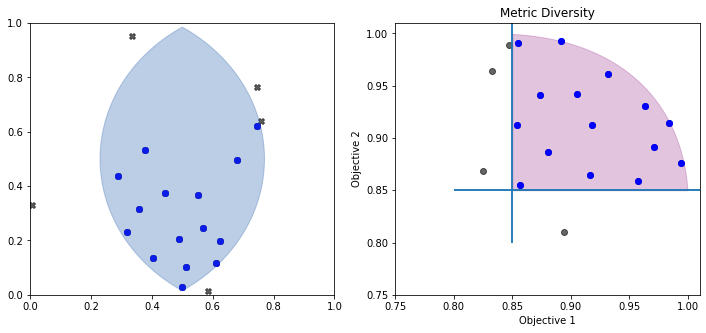

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(emcs_points[:, 0], emcs_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(emcs_points[emcs_feasible_inds, 0], emcs_points[emcs_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(emcs_values[:, 0], emcs_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(emcs_values[emcs_feasible_inds, 0], emcs_values[emcs_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Metric Diversity")
plt.show()

### EMI Problem from Mike

In [12]:
emi = EMI()

In [13]:
cas = ConstraintActiveSearchService(
  parameters=emi.parameters,
  constraints=emi.constraints,
  punchout_radius=emi.punchout_radius_param,
  num_init_points=5 * len(emi.parameters),
)

In [14]:
for i in range(100):
  suggestion = cas.create_suggestion()
  values = emi.evaluate(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  cas.create_observation(observation)

 >>> x_next tensor([[0.1663, 0.4748, 0.2239, 0.7642, 0.3290]], dtype=torch.float64) eci tensor(0.7916, dtype=torch.float64)
 >>> x_next tensor([[0.0000, 0.6709, 0.4256, 1.0000, 0.3292]], dtype=torch.float64) eci tensor(0.7592, dtype=torch.float64)
 >>> x_next tensor([[0.0000, 0.6921, 0.0000, 1.0000, 0.3062]], dtype=torch.float64) eci tensor(0.7779, dtype=torch.float64)
 >>> x_next tensor([[0.0000, 0.2715, 0.0000, 0.6155, 0.3518]], dtype=torch.float64) eci tensor(0.7776, dtype=torch.float64)
 >>> x_next tensor([[0.0000, 0.2617, 0.0000, 1.0000, 0.3165]], dtype=torch.float64) eci tensor(0.8182, dtype=torch.float64)
 >>> x_next tensor([[0.3357, 0.2594, 0.0000, 0.5687, 0.3285]], dtype=torch.float64) eci tensor(0.7870, dtype=torch.float64)
 >>> x_next tensor([[1.4046e-01, 2.5373e-04, 0.0000e+00, 3.9609e-01, 3.6675e-01]],
       dtype=torch.float64) eci tensor(0.6854, dtype=torch.float64)
 >>> x_next tensor([[0.2697, 0.7291, 0.2107, 1.0000, 0.3029]], dtype=torch.float64) eci tensor(0.6360, dt

 >>> x_next tensor([[0.1032, 0.3900, 0.2663, 0.8353, 0.4469]], dtype=torch.float64) eci tensor(0.0286, dtype=torch.float64)
 >>> x_next tensor([[0.3542, 0.0124, 0.0127, 0.4005, 0.3352]], dtype=torch.float64) eci tensor(0.0377, dtype=torch.float64)
 >>> x_next tensor([[0.0407, 0.5749, 0.3863, 0.6432, 0.1914]], dtype=torch.float64) eci tensor(0.0310, dtype=torch.float64)
 >>> x_next tensor([[0.2773, 0.7719, 0.2134, 0.8386, 0.3682]], dtype=torch.float64) eci tensor(0.0223, dtype=torch.float64)
 >>> x_next tensor([[0.0160, 0.5737, 0.1302, 0.7781, 0.3651]], dtype=torch.float64) eci tensor(0.0348, dtype=torch.float64)
 >>> x_next tensor([[0.2138, 0.4292, 0.3782, 0.9041, 0.3652]], dtype=torch.float64) eci tensor(0.0300, dtype=torch.float64)
 >>> x_next tensor([[0.5438, 0.2047, 0.0037, 0.8000, 0.3744]], dtype=torch.float64) eci tensor(0.0350, dtype=torch.float64)
 >>> x_next tensor([[0.3149, 0.2701, 0.2339, 0.6571, 0.3529]], dtype=torch.float64) eci tensor(0.0275, dtype=torch.float64)
 >>> x_n

In [15]:
cas_points = numpy.array(cas.get_points())
cas_values = numpy.array(cas.get_values())
cas_feasible_inds = numpy.array(cas.get_feasible_indices())

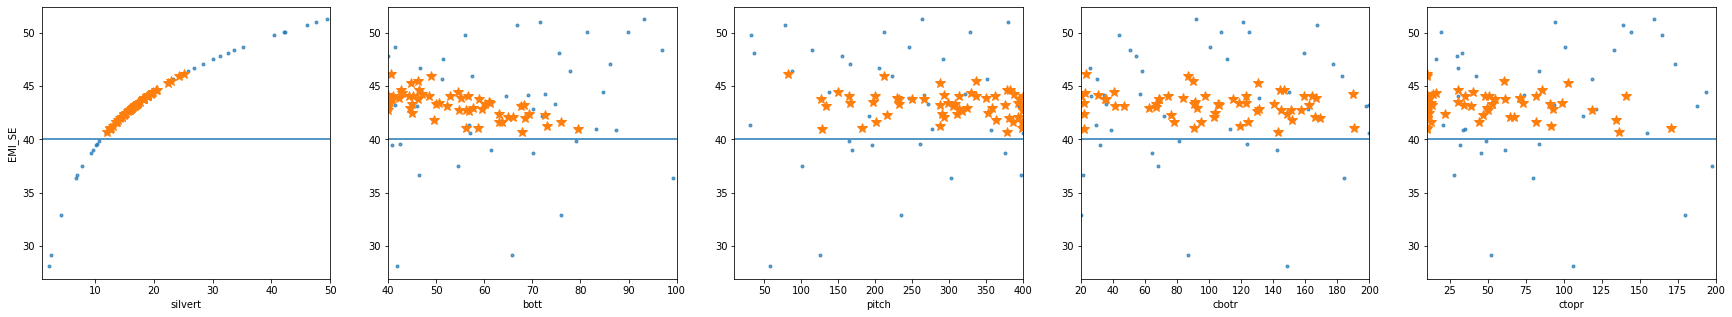

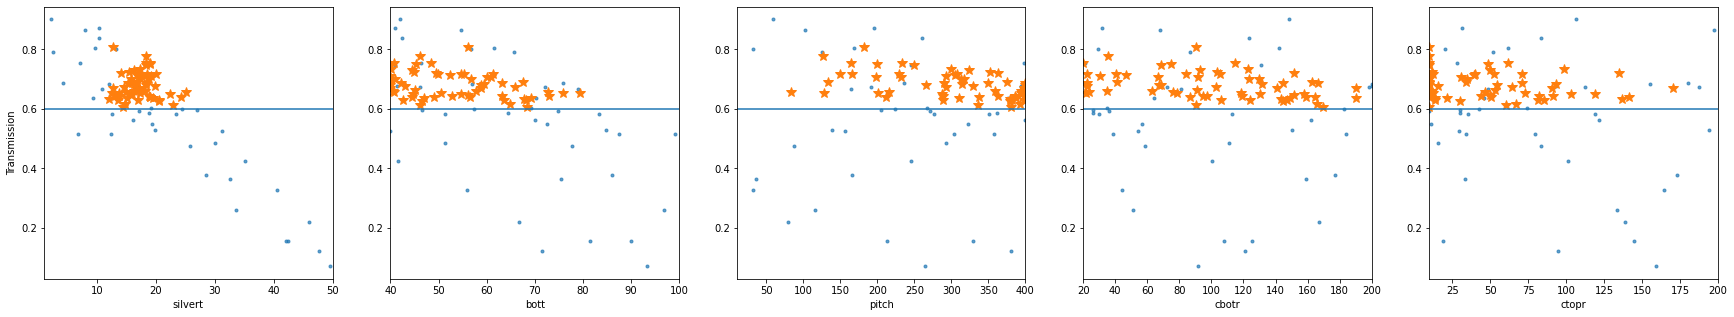

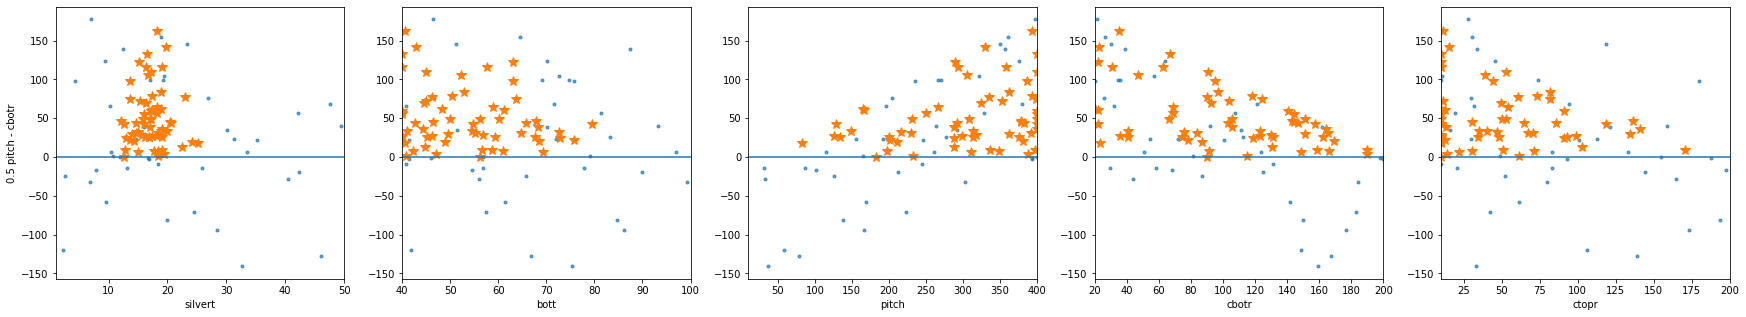

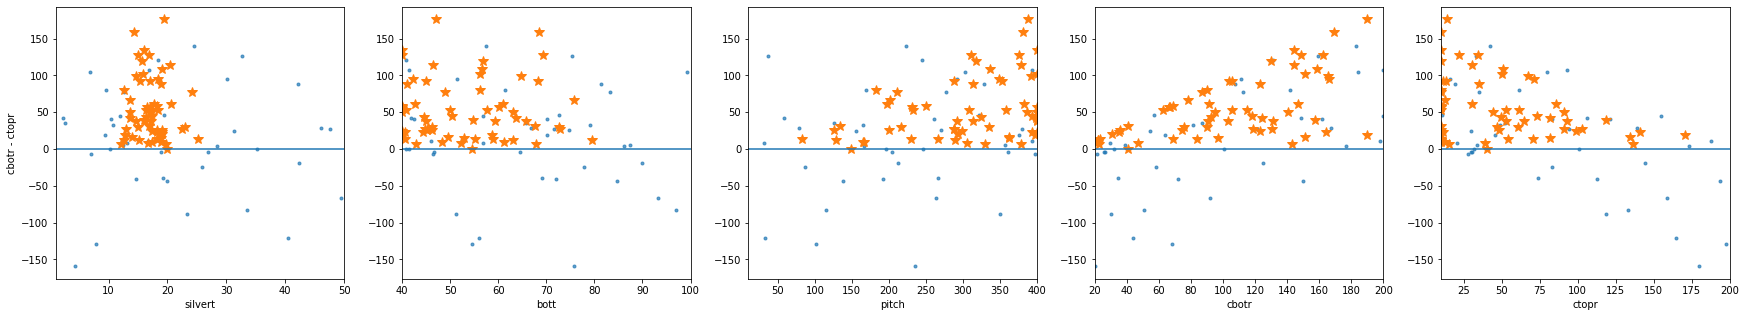

In [16]:
for i, m_name in enumerate(emi.metric_names):
  fig, axes = plt.subplots(1, len(emi.parameters), figsize=(6 * len(emi.parameters), 5))
  for j, ax in enumerate(axes):
    cas_param_idx = cas.domain.parameters_name.index(emi.parameters[j]["name"])
    ax.plot(cas_points[:, cas_param_idx], cas_values[:, i], ".", alpha=0.7)
    ax.plot(cas_points[cas_feasible_inds, cas_param_idx], cas_values[cas_feasible_inds, i], "*", markersize=10)
    ax.hlines(emi.thresholds[i], emi.parameters[j]["bounds"]["min"], emi.parameters[j]["bounds"]["max"])
    ax.set_xlim([emi.parameters[j]["bounds"]["min"], emi.parameters[j]["bounds"]["max"]])
    ax.set_xlabel(emi.parameter_names[j])
  axes[0].set_ylabel(m_name)

In [17]:
emcs = ExpectedMetricCoverageService(
  parameters=emi.parameters,
  constraints=emi.constraints,
  punchout_radius=emi.punchout_radius_metric,
  num_init_points=5 * len(emi.parameters),
  hyperparameters=emi.fixed_lengthscales,
)

In [18]:
for i in range(100):
  suggestion = emcs.create_suggestion()
  values = emi.evaluate(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  emcs.create_observation(observation)

 >>> x_next [12.34111703 61.64023126 60.29609051 20.         10.        ] emc 0.94140625
 >>> x_next [12.1857002  63.63324968 84.04639884 20.         13.73023758] emc 0.984375
 >>> x_next [ 12.02706147  65.76487641 133.66754625  20.          10.        ] emc 0.974609375
 >>> x_next [12.02242558 64.22766095 99.91415285 37.94059402 10.        ] emc 1.0
 >>> x_next [12.53237851 61.46027564 91.17903459 43.26054582 10.        ] emc 1.0
 >>> x_next [ 13.05328846  60.91349864 110.68544272  32.79011189  10.        ] emc 1.0
 >>> x_next [ 13.68711561  61.03402508 165.16285845  20.          10.        ] emc 0.990234375
 >>> x_next [ 12.5762421   58.43940911 162.51285948  52.5689649   10.        ] emc 1.0
 >>> x_next [ 13.17260893  60.64678858 201.42134065  43.01412224  10.        ] emc 1.0
 >>> x_next [ 13.30125205  57.23699446 217.23862393  66.22281711  19.6919957 ] emc 1.0
 >>> x_next [ 11.91376217  60.65148964 196.97732094  74.09252169  10.        ] emc 1.0
 >>> x_next [ 11.90515915  60.49241

In [19]:
emcs_points = numpy.array(emcs.get_points())
emcs_values = numpy.array(emcs.get_values())
emcs_feasible_inds = numpy.array(emcs.get_feasible_indices())

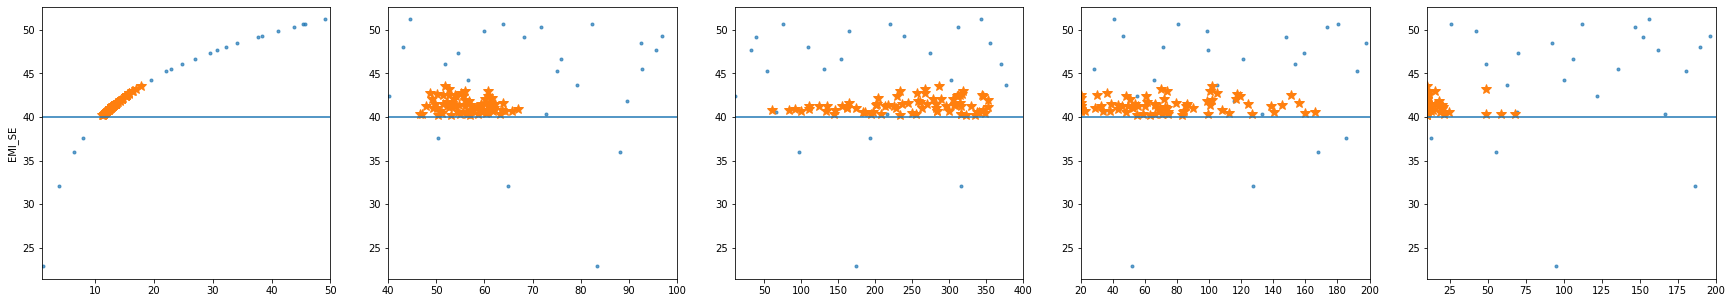

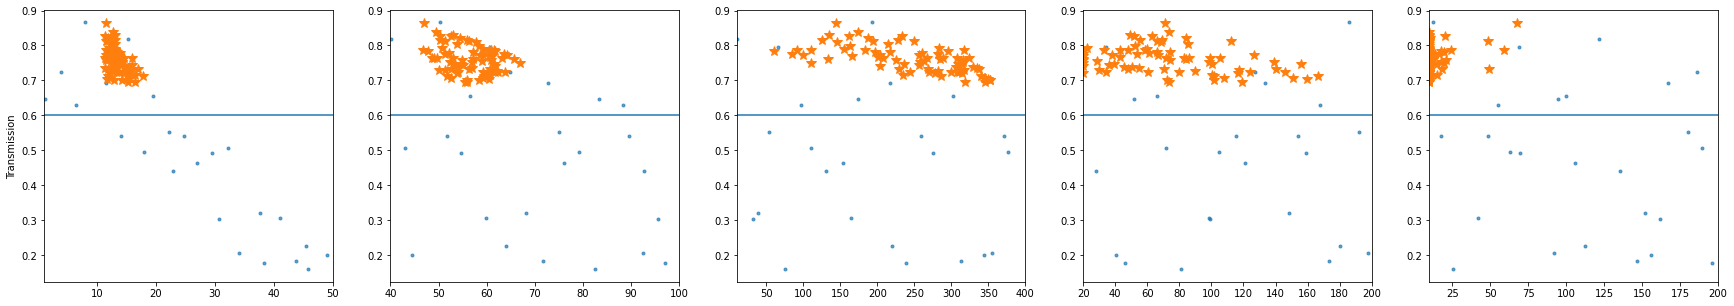

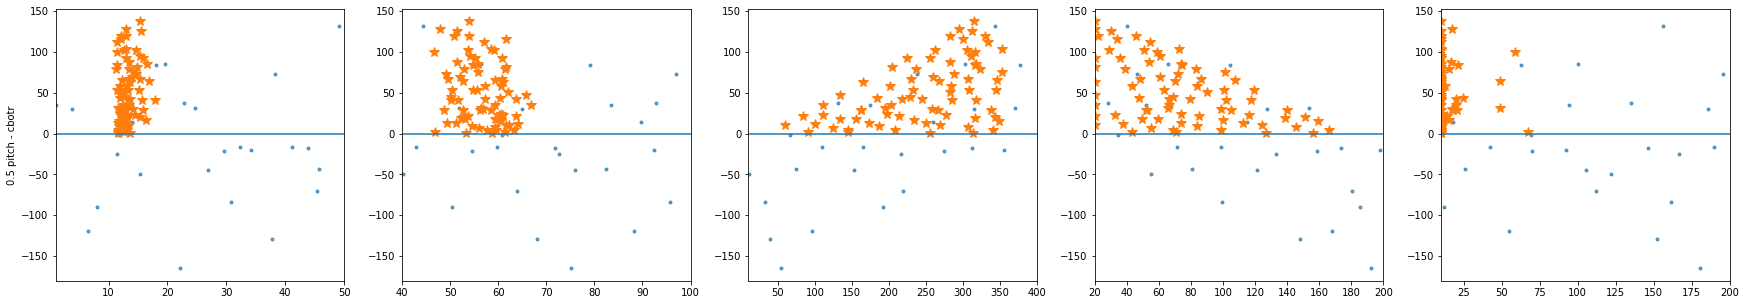

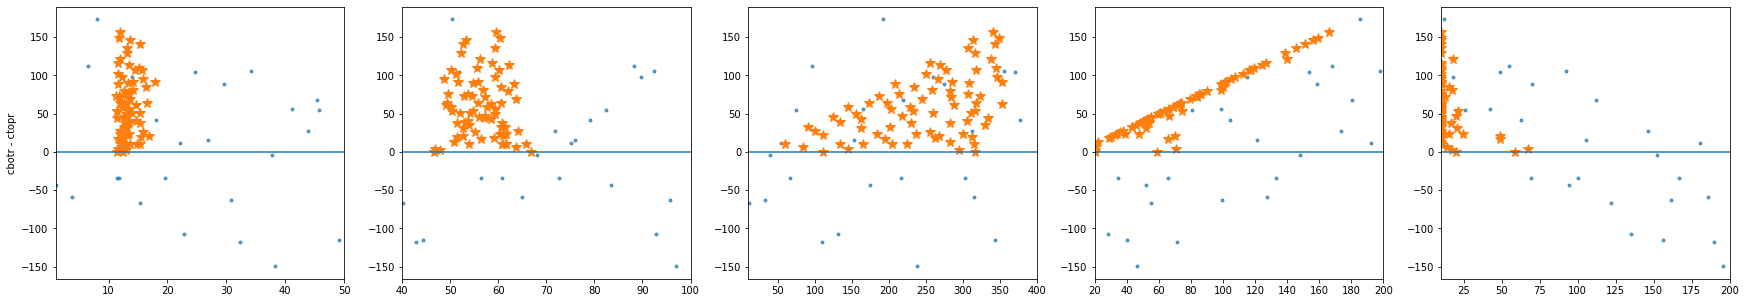

In [20]:
for i, m_name in enumerate(emi.metric_names):
  fig, axes = plt.subplots(1, len(emi.parameters), figsize=(6 * len(emi.parameters), 5))
  for j, ax in enumerate(axes):
    ax.plot(emcs_points[:, j], emcs_values[:, i], ".", alpha=0.7)
    ax.plot(emcs_points[emcs_feasible_inds, j], emcs_values[emcs_feasible_inds, i], "*", markersize=10)
    ax.hlines(emi.thresholds[i], emi.parameters[j]["bounds"]["min"], emi.parameters[j]["bounds"]["max"])
    ax.set_xlim([emi.parameters[j]["bounds"]["min"], emi.parameters[j]["bounds"]["max"]])
  axes[0].set_ylabel(m_name)

## Try different punchout radius

In [21]:
emcs = ExpectedMetricCoverageService(
  parameters=emi.parameters,
  constraints=emi.constraints,
  punchout_radius=25,
  num_init_points=5 * len(emi.parameters),
  hyperparameters=emi.fixed_lengthscales,
)

In [22]:
for i in range(100):
  suggestion = emcs.create_suggestion()
  values = emi.evaluate(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  emcs.create_observation(observation)

 >>> x_next [ 16.90895558  54.95424783 120.8549983   25.75286711  10.        ] emc 0.869140625
 >>> x_next [ 15.54304983  54.08505557 167.0235077   20.          10.        ] emc 0.900390625
 >>> x_next [ 14.04083754  51.80259901 188.57848059  76.53939492  10.        ] emc 0.947265625
 >>> x_next [ 14.66316219  50.39994788 226.67747855  69.62620421  10.        ] emc 0.951171875
 >>> x_next [ 15.49269052  51.90307808 227.56239757  20.          10.        ] emc 1.0
 >>> x_next [ 17.21022474  48.80599096 279.18304664 120.68001986  27.55002472] emc 0.83984375
 >>> x_next [ 17.8913802   51.73367669 185.73984818  84.64736926  76.85893893] emc 0.9609375
 >>> x_next [ 14.59730833  51.12564659 262.62770893  56.89858117  14.98812413] emc 1.0
 >>> x_next [ 13.85402108  51.34948296 305.12681478  90.30645526  10.        ] emc 0.974609375
 >>> x_next [ 13.18508105  51.42189087 323.77024286 120.36291569  10.        ] emc 1.0
 >>> x_next [ 14.69261425  52.96237644 296.01015439  20.          10.        

In [23]:
emcs_points = numpy.array(emcs.get_points())
emcs_values = numpy.array(emcs.get_values())
emcs_feasible_inds = numpy.array(emcs.get_feasible_indices())

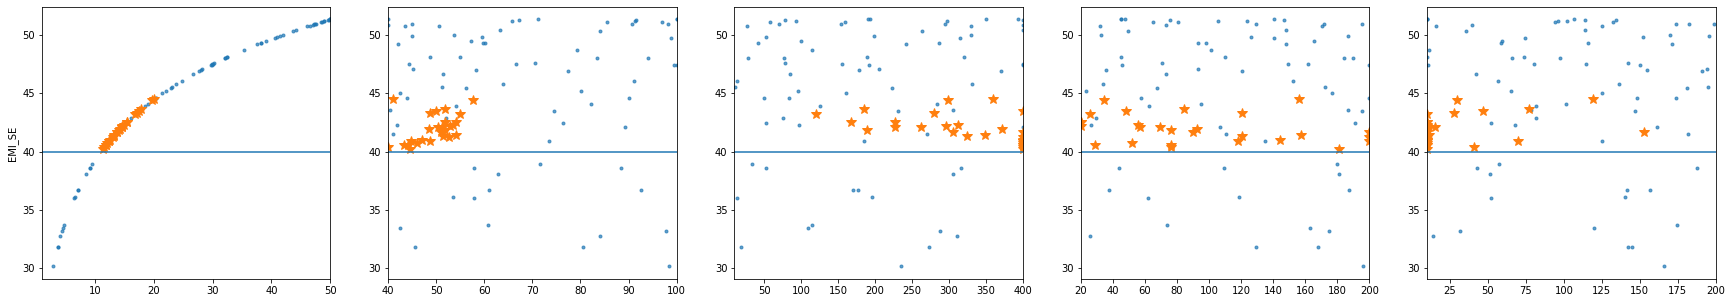

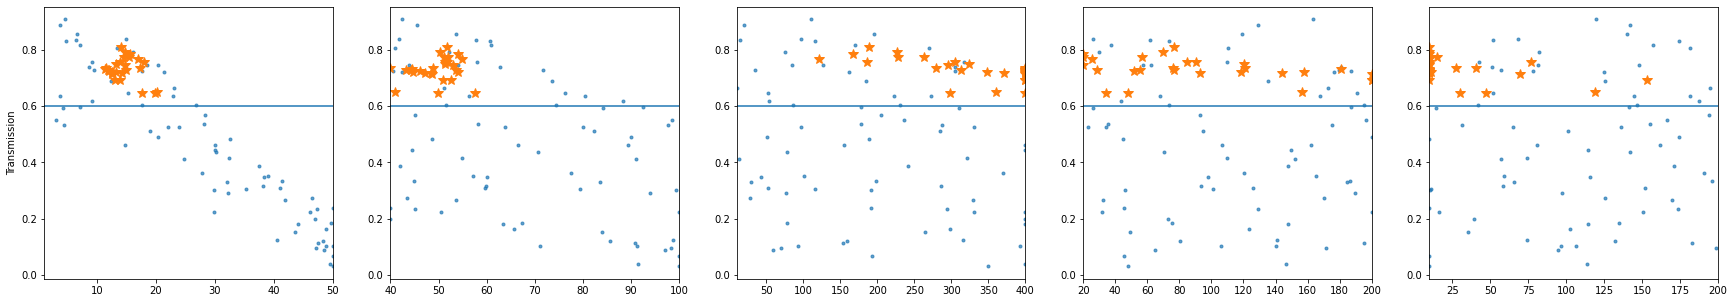

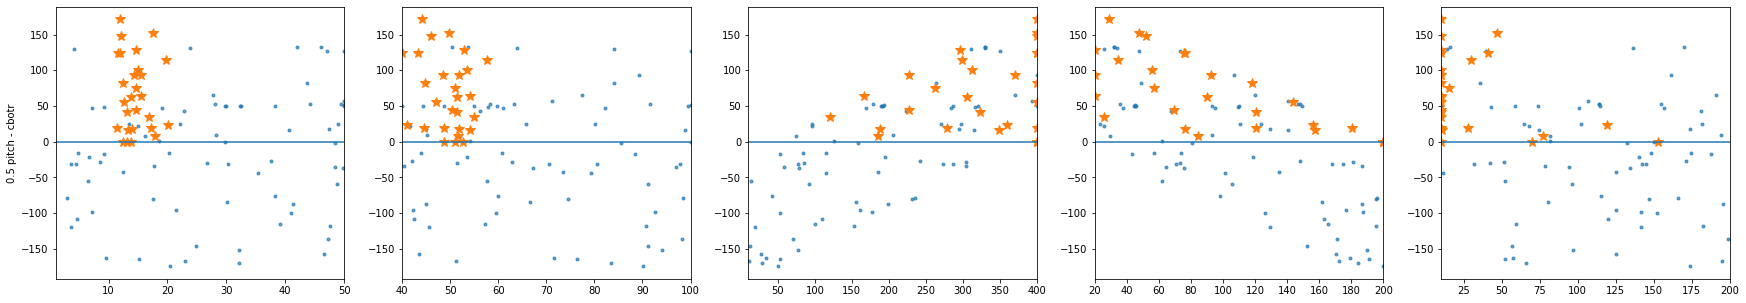

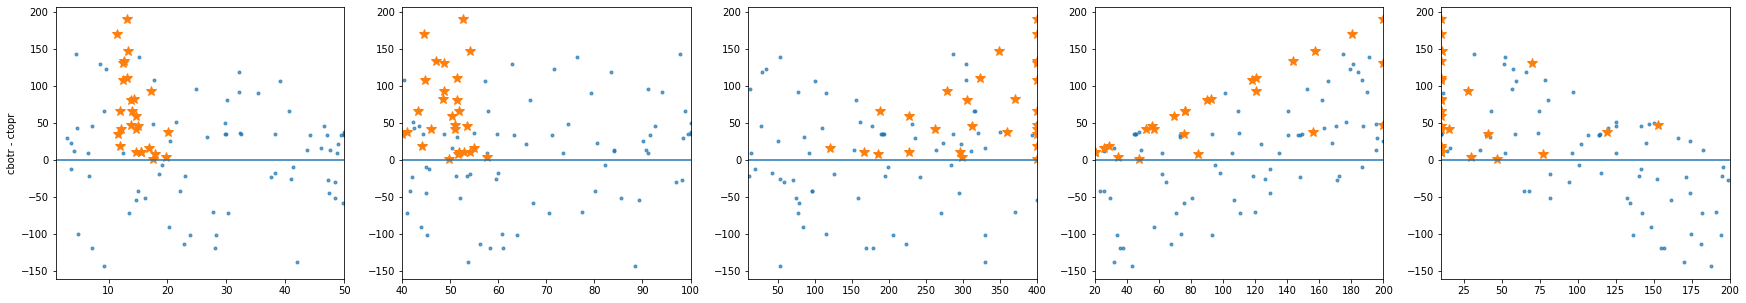

In [24]:
for i, m_name in enumerate(emi.metric_names):
  fig, axes = plt.subplots(1, len(emi.parameters), figsize=(6 * len(emi.parameters), 5))
  for j, ax in enumerate(axes):
    ax.plot(emcs_points[:, j], emcs_values[:, i], ".", alpha=0.7)
    ax.plot(emcs_points[emcs_feasible_inds, j], emcs_values[emcs_feasible_inds, i], "*", markersize=10)
    ax.hlines(emi.thresholds[i], emi.parameters[j]["bounds"]["min"], emi.parameters[j]["bounds"]["max"])
    ax.set_xlim([emi.parameters[j]["bounds"]["min"], emi.parameters[j]["bounds"]["max"]])
  axes[0].set_ylabel(m_name)